<a href="https://colab.research.google.com/github/muyonaise/projects/blob/main/AP2_associated_protein_kinase_1_inhibitors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cheminformatics COVID project - Baricitinib proposed as a potential treated for COVID-19: Collecting, processing and initial analysis of data**

https://www.thelancet.com/action/showPdf?pii=S0140-6736%2820%2930304-4

"Disruption of AAK1 might,
in turn, interrupt the passage of the
virus into cells and also the intracellular
assembly of virus particles"

## **Setting up**

In [ ]:
! pip install kora
! pip install chembl_webresource_client
import kora.install.rdkit

     |████████████████████████████████| 61kB 3.3MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 61kB 3.2MB/s 
  Created wheel for chembl-webresource-client: filename=chembl_webresource_client-0.10.2-cp36-none-any.whl size=55662 sha256=e8be6b40b586c8d4b249746fbd70fc181cdd77c9b9bc97e38f7d93350d0cc8aa
  Stored in directory: /root/.cache/pip/wheels/e6/96/19/3f042bfda7c669bfe24c8278477f57b0fbbf3e488b4c09e3a8
Successfully built chembl-webresource-client


In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors, Lipinski
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
from chembl_webresource_client.new_client import new_client

## **Searching for regulator of endocytosis, AAK1, and drugs known to inhibit its activity**

### **AAK1**

In [ ]:
# Searching the ChEMBL database for AP2-associated protein kinase 1's target report card
target = new_client.target
target_query = target.search('AAK1')
targets = pd.DataFrame(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'AAK1', 'xref_name': None, 'xref_...",Homo sapiens,Adaptor-associated kinase,17.0,False,CHEMBL3830,"[{'accession': 'Q2M2I8', 'component_descriptio...",SINGLE PROTEIN,9606


In [ ]:
targets.target_chembl_id[0]

'CHEMBL3830'

### **Bioactivity data for AAK1**

We now search for the bioactivity data of potential drugs to inhibit AAK1

So initially I only looked for activities of units IC50 only, and neglected those with other units as to avoid confusion/incorrect units
```
bioactivity = new_client.activity
leads = bioactivity.filter(target_chembl_id=targets.target_chembl_id[0]).filter(standard_type="IC50")
```

However that only gave me 10 hits... It might be tricky to fit anything to that

In [ ]:
bioactivity = new_client.activity
ld = bioactivity.filter(target_chembl_id=targets.target_chembl_id[0]).filter(standard_type="IC50")
df_ld = pd.DataFrame(ld)
len(df_ld)

10

In [ ]:
# drop any data with empty activity entries and remove duplicates
df_ld2 = df_ld[df_ld.standard_value.notna()]
df_ld2.drop_duplicates(subset='molecule_chembl_id')
len(df_ld2)

9

In [ ]:
selected_ld = df_ld2[['molecule_pref_name','molecule_chembl_id','canonical_smiles','standard_value']]
selected_ld

,molecule_pref_name,molecule_chembl_id,canonical_smiles,standard_value
1,None,CHEMBL2205766,CC(C)(C)NS(=O)(=O)c1cncc(-c2ccn3nc(N)nc3c2)c1,5888.44
2,None,CHEMBL4085072,CC(C)C[C@](C)(N)COc1ccc(-c2ccnc3ccccc23)cc1C1CC1,0.07
3,None,CHEMBL4103020,Cc1cc(-c2ccc(OC[C@@](C)(N)CC(C)C)c(S(C)(=O)=O)...,1400.0
4,None,CHEMBL4092824,Cc1cc(-c2cc(C(F)F)c(OC[C@@](C)(N)CC(C)C)cn2)ccn1,0.51
5,None,CHEMBL4065155,CC(C)C[C@](C)(N)COc1ncc(-c2ccnc3ccccc23)cc1C(F)F,0.23
6,None,CHEMBL4066208,CC(C)C[C@](C)(N)COc1ccc(-c2ccnc(C(C)C)n2)cc1F,886.0
7,None,CHEMBL4073745,COc1cc(-c2ccnc(NC(C)=O)c2)ccc1OC[C@@H](N)CC(C)C,3.0
8,None,CHEMBL4084103,COC(=O)Nc1cc(-c2ccc(OC[C@@](C)(N)CC(C)C)c(C3CC...,0.32
9,None,CHEMBL4062388,CC(=O)Nc1cc(-c2ccc(OC[C@@H](N)CC(C)C)c(C)c2)ccn1,0.42


As the dataset is so small we can visualise these 9 molecules using RDKit. Maybe Baricitinib is one of them

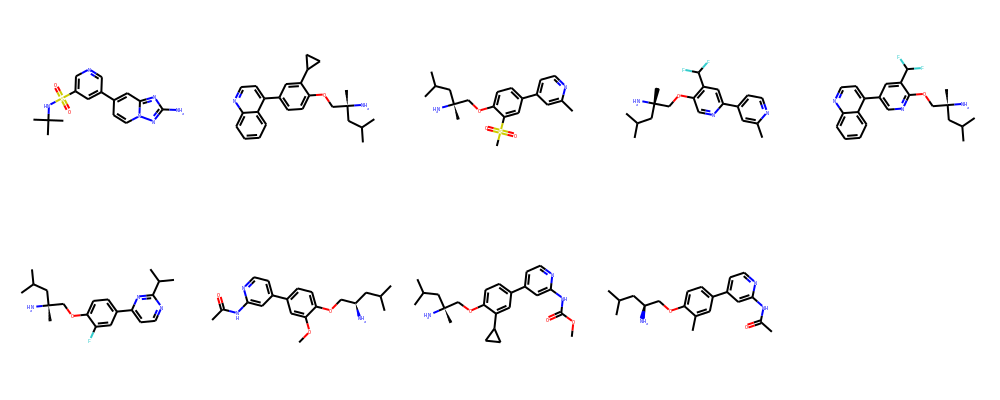

In [ ]:
mol_list = []
for m in selected_ld['canonical_smiles']:
  mol = Chem.MolFromSmiles(m)
  mol_list.append(mol)

Draw.MolsToGridImage(mol_list, molsPerRow=5)

Nope. No baricitinib to be found. But one could do some further studies on these structures. Especially those with IC50s < 1000 nM. As that suggests only small concentrations of them are required to inhibit AAK1 to 50%.

### **A broader search**

In [ ]:
# ok first lets find out what the most common activity type is
leads = bioactivity.filter(target_chembl_id=targets.target_chembl_id[0])

In [ ]:
df_leads = pd.DataFrame(leads)
len(df_leads)

466

Let's check the list of leads for Baricitinib (CHEMBL2105759)
https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL2105759/

In [ ]:
df_leads.loc[df_leads.molecule_chembl_id == 'CHEMBL2105759']

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
421,Active,17878374,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL3991602,"Kinobeads (epsilon), multiple immobilized ATP-...",B,BAO_0000179,BAO_0000220,subcellular format,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)c...,None,None,CHEMBL3991601,Science,2017,None,CHEMBL2105759,BARICITINIB,CHEMBL2105759,None,False,http://www.openphacts.org/units/Nanomolar,2973632,=,48,False,=,None,Kd apparent,nM,None,46.0,CHEMBL3830,Homo sapiens,Adaptor-associated kinase,9606,None,None,Kd apparent,nM,UO_0000065,None,46.0


In [ ]:
df_leads.standard_type.mode()

0    Kd apparent
dtype: object

So the majority of the data in the database uses units of *apparent* $K_d$, the dissociation constant. Kd can be used to describe the affinity of a drug to a protein (how well they bind to form a ligand-protein complex).

$K_d = \frac{[Drug][Protein]}{[D-P]}$

$K_d$ corresponds to the drug concentration required for 50% of the proteins to be inhibited at equilibrium. We will deem drugs with $K_d < 1000 nM$ as active and look out for those that are highly active $<10nm$.

In [ ]:
kd_ld = bioactivity.filter(target_chembl_id=targets.target_chembl_id[0]).filter(standard_type='Kd apparent')
df_kdld = pd.DataFrame(kd_ld)
len(df_kdld)

243

In [ ]:
# lets get rid of empty standard activity values or broken smiles & any duplicates and then reset the index
# we reset the index as we will be adding bioactivity labels next and the index of the entry
# and the label needs to match
df_kdld2 = df_kdld[df_kdld.standard_value.notna()]
df_kdld2 = df_kdld2[df_kdld2.canonical_smiles.notna()]
cleanup = df_kdld2.drop_duplicates(subset='molecule_chembl_id', keep='last').reset_index()
cleanup

,index,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,0,Active,17878157,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL3991602,"Kinobeads (epsilon), multiple immobilized ATP-...",B,BAO_0000179,BAO_0000220,subcellular format,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,None,None,CHEMBL3991601,Science,2017,None,CHEMBL3301610,ABEMACICLIB,CHEMBL3301610,None,False,http://www.openphacts.org/units/Nanomolar,2973415,=,48,False,=,None,Kd apparent,nM,None,102.0,CHEMBL3830,Homo sapiens,Adaptor-associated kinase,9606,None,None,Kd apparent,nM,UO_0000065,None,102.0
1,1,Inactive,17878158,[],CHEMBL3991602,"Kinobeads (epsilon), multiple immobilized ATP-...",B,BAO_0000179,BAO_0000220,subcellular format,CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...,None,None,CHEMBL3991601,Science,2017,None,CHEMBL2220486,LUCITANIB,CHEMBL2220486,None,False,http://www.openphacts.org/units/Nanomolar,2973416,>,48,False,>,None,Kd apparent,nM,None,30000.0,CHEMBL3830,Homo sapiens,Adaptor-associated kinase,9606,None,None,Kd apparent,nM,UO_0000065,None,30000.0
2,2,Active,17878159,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL3991602,"Kinobeads (epsilon), multiple immobilized ATP-...",B,BAO_0000179,BAO_0000220,subcellular format,CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...,None,None,CHEMBL3991601,Science,2017,None,CHEMBL535,SUNITINIB,CHEMBL535,None,False,http://www.openphacts.org/units/Nanomolar,2973417,=,48,False,=,None,Kd apparent,nM,None,363.0,CHEMBL3830,Homo sapiens,Adaptor-associated kinase,9606,None,None,Kd apparent,nM,UO_0000065,None,363.0
3,3,Inactive,17878160,[],CHEMBL3991602,"Kinobeads (epsilon), multiple immobilized ATP-...",B,BAO_0000179,BAO_0000220,subcellular format,NC(=O)c1c(OCc2c(F)cc(Br)cc2F)nsc1NC(=O)NCCCCN1...,None,None,CHEMBL3991601,Science,2017,None,CHEMBL253969,OSI-632,CHEMBL253969,None,False,http://www.openphacts.org/units/Nanomolar,2973418,>,48,False,>,None,Kd apparent,nM,None,30000.0,CHEMBL3830,Homo sapiens,Adaptor-associated kinase,9606,None,None,Kd apparent,nM,UO_0000065,None,30000.0
4,4,Inactive,17878161,[],CHEMBL3991602,"Kinobeads (epsilon), multiple immobilized ATP-...",B,BAO_0000179,BAO_0000220,subcellular format,C#Cc1cccc(Nc2ncnc3cc4c(cc23)OCCOCCOCCO4)c1,None,None,CHEMBL3991601,Science,2017,None,CHEMBL2087361,ICOTINIB,CHEMBL2087361,None,False,http://www.openphacts.org/units/Nanomolar,2973419,>,48,False,>,None,Kd apparent,nM,None,30000.0,CHEMBL3830,Homo sapiens,Adaptor-associated kinase,9606,None,None,Kd apparent,nM,UO_0000065,None,30000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,238,Inactive,17878395,[],CHEMBL3991602,"Kinobeads (epsilon), multiple immobilized ATP-...",B,BAO_0000179,BAO_0000220,subcellular format,O=S(=O)(c1cccc2cnccc12)N1CCCNCC1,None,None,CHEMBL3991601,Science,2017,None,CHEMBL38380,FASUDIL,CHEMBL38380,None,False,http://www.openphacts.org/units/Nanomolar,2973653,>,48,False,>,None,Kd apparent,nM,None,30000.0,CHEMBL3830,Homo sapiens,Adaptor-associated kinase,9606,None,None,Kd apparent,nM,UO_0000065,None,30000.0
238,239,Inactive,17878396,[],CHEMBL3991602,"Kinobeads (epsilon), multiple immobilized ATP-...",B,BAO_0000179,BAO_0000220,subcellular format,COc1cc(Nc2ncc(F)c(Nc3ccc4c(n3)N(COP(=O)(O)O)C(...,None,None,CHEMBL3991601,Science,2017,None,CHEMBL2103830,FOSTAMATINIB,CHEMBL210383

In [ ]:
len(cleanup)

242

In [ ]:
cleanup.standard_value.describe()

count         242
unique         50
top       30000.0
freq          192
Name: standard_value, dtype: object

## **Some pre-processing and saving of the data**

Let's take the most important columns for this analysis

In [ ]:
df_kdld3 = cleanup[['molecule_pref_name','molecule_chembl_id','canonical_smiles','standard_value']]
df_kdld3.head()

,molecule_pref_name,molecule_chembl_id,canonical_smiles,standard_value
0,ABEMACICLIB,CHEMBL3301610,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,102.0
1,LUCITANIB,CHEMBL2220486,CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...,30000.0
2,SUNITINIB,CHEMBL535,CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...,363.0
3,OSI-632,CHEMBL253969,NC(=O)c1c(OCc2c(F)cc(Br)cc2F)nsc1NC(=O)NCCCCN1...,30000.0
4,ICOTINIB,CHEMBL2087361,C#Cc1cccc(Nc2ncnc3cc4c(cc23)OCCOCCOCCO4)c1,30000.0


In [ ]:
len(df_kdld3)

242

In [ ]:
activity_list = []
for i in df_kdld3.standard_value:
  if 10 < float(i) <= 1000:
    activity_list.append("active")
  elif float(i) <= 10:
    activity_list.append("highly active")
  elif float(i) >= 10000:
    activity_list.append("inactive")
#  else:
  elif 1000 < float(i) < 10000:
    activity_list.append("intermediate activity")

In [ ]:
df_act = pd.Series(activity_list, name='bioactivity')
len(df_act)

242

In [ ]:
df_data = pd.concat([df_kdld3, df_act], axis=1)
df_data

,molecule_pref_name,molecule_chembl_id,canonical_smiles,standard_value,bioactivity
0,ABEMACICLIB,CHEMBL3301610,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,102.0,active
1,LUCITANIB,CHEMBL2220486,CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...,30000.0,inactive
2,SUNITINIB,CHEMBL535,CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...,363.0,active
3,OSI-632,CHEMBL253969,NC(=O)c1c(OCc2c(F)cc(Br)cc2F)nsc1NC(=O)NCCCCN1...,30000.0,inactive
4,ICOTINIB,CHEMBL2087361,C#Cc1cccc(Nc2ncnc3cc4c(cc23)OCCOCCOCCO4)c1,30000.0,inactive
...,...,...,...,...,...
237,FASUDIL,CHEMBL38380,O=S(=O)(c1cccc2cnccc12)N1CCCNCC1,30000.0,inactive
238,FOSTAMATINIB,CHEMBL2103830,COc1cc(Nc2ncc(F)c(Nc3ccc4c(n3)N(COP(=O)(O)O)C(...,30000.0,inactive
239,TIVANTINIB,CHEMBL2103882,O=C1NC(=O)[C@@H](c2cn3c4c(cccc24)CCC3)[C@@H]1c...,30000.0,inactive
240,AXITINIB,CHEMBL1289926,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,2159.0,intermediate activity


Let's have a quick look at what molecules are highly active

In [ ]:
HA_data = df_data.loc[df_data['bioactivity'] == 'highly active']
HA_data

,molecule_pref_name,molecule_chembl_id,canonical_smiles,standard_value,bioactivity
18,None,CHEMBL1983111,CC(=O)NCC(=O)N1C2CCC1c1cc(Nc3ncc(C(F)(F)F)c(NC...,9.0,highly active
50,CYC-116,CHEMBL482967,Cc1nc(N)sc1-c1ccnc(Nc2ccc(N3CCOCC3)cc2)n1,6.0,highly active
84,MOMELOTINIB,CHEMBL1078178,N#CCNC(=O)c1ccc(-c2ccnc(Nc3ccc(N4CCOCC4)cc3)n2...,4.0,highly active
91,None,CHEMBL3991929,CCS(=O)(=O)N1CCN(c2ccc(Nc3ncc(C(N)=O)c(NC4CC4)...,1.0,highly active
95,PF-00477736,CHEMBL3545137,Cn1cc(-c2nc3cc(NC(=O)C(N)C4CCCCC4)cc4c3-c2c[nH...,2.0,highly active
185,XL-019,CHEMBL3545328,O=C(Nc1ccc(-c2ccnc(Nc3ccc(N4CCOCC4)cc3)n2)cc1)...,6.0,highly active
191,K-252A,CHEMBL281948,COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...,5.0,highly active


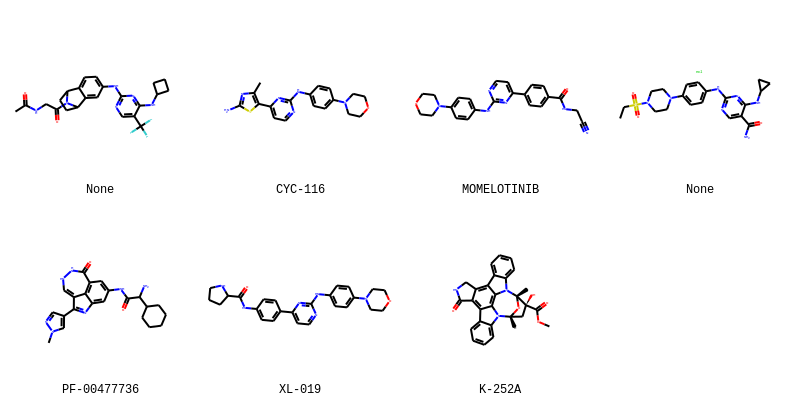

In [ ]:
HA_mol_list = []
for i in HA_data.canonical_smiles:
  ha_mol = Chem.MolFromSmiles(i)
  HA_mol_list.append(ha_mol)

Draw.MolsToGridImage(HA_mol_list, molsPerRow=4, legends=[str(x) for x in HA_data.molecule_pref_name])

In [ ]:
# saving without an index
df_data.to_csv('AAK1_preprocessed_bioactivity_data.csv', index=False)

## **Calculating the Lipinski Descriptors**

Calculating the:


*   Molecular weight
*   Octanol-Water partition coeff
*   No. of H-bond donors
*   No. of H-bond acceptors



In [ ]:
molecular_data = []
for i in df_data.canonical_smiles:
  mol = Chem.MolFromSmiles(i)
  molecular_data.append(mol)

In [ ]:
# create empty list to fill
empty = []

for mol in molecular_data:
  descript_mw = Descriptors.MolWt(mol)
  descript_logp = Descriptors.MolLogP(mol)
  descript_hdon = Lipinski.NumHDonors(mol)
  descript_hacc = Lipinski.NumHAcceptors(mol)

  descriptors = ([descript_mw,descript_logp,descript_hdon,descript_hacc])

  empty.append(descriptors)

In [ ]:
column_labels = ["MW","LogP","No_H-Donors","No_H-Acceptors"]
df_des = pd.DataFrame(empty, columns=column_labels)
df_des

,MW,LogP,No_H-Donors,No_H-Acceptors
0,506.605,4.93692,1,8
1,443.503,4.41860,2,6
2,398.482,3.33494,3,3
3,532.411,3.85920,3,6
4,391.427,3.15910,1,7
...,...,...,...,...
237,291.376,1.21880,1,4
238,580.466,3.09450,4,12
239,369.424,3.59260,2,3
240,386.480,4.63910,2,4


In [ ]:
combined_info = pd.concat([df_data, df_des], axis=1)
combined_info

,molecule_pref_name,molecule_chembl_id,canonical_smiles,standard_value,bioactivity,MW,LogP,No_H-Donors,No_H-Acceptors
0,ABEMACICLIB,CHEMBL3301610,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,102.0,active,506.605,4.93692,1,8
1,LUCITANIB,CHEMBL2220486,CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...,30000.0,inactive,443.503,4.41860,2,6
2,SUNITINIB,CHEMBL535,CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...,363.0,active,398.482,3.33494,3,3
3,OSI-632,CHEMBL253969,NC(=O)c1c(OCc2c(F)cc(Br)cc2F)nsc1NC(=O)NCCCCN1...,30000.0,inactive,532.411,3.85920,3,6
4,ICOTINIB,CHEMBL2087361,C#Cc1cccc(Nc2ncnc3cc4c(cc23)OCCOCCOCCO4)c1,30000.0,inactive,391.427,3.15910,1,7
...,...,...,...,...,...,...,...,...,...
237,FASUDIL,CHEMBL38380,O=S(=O)(c1cccc2cnccc12)N1CCCNCC1,30000.0,inactive,291.376,1.21880,1,4
238,FOSTAMATINIB,CHEMBL2103830,COc1cc(Nc2ncc(F)c(Nc3ccc4c(n3)N(COP(=O)(O)O)C(...,30000.0,inactive,580.466,3.09450,4,12
239,TIVANTINIB,CHEMBL2103882,O=C1NC(=O)[C@@H](c2cn3c4c(cccc24)CCC3)[C@@H]1c...,30000.0,inactive,369.424,3.59260,2,3
240,AXITINIB,CHEMBL1289926,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,2159.0,intermediate activity,386.480,4.63910,2,4


In [ ]:
combined_info.describe()

,MW,LogP,No_H-Donors,No_H-Acceptors
count,242.000000,242.000000,242.000000,242.000000
mean,462.118620,3.862090,2.074380,6.760331
std,99.243564,1.417905,0.990957,2.049288
min,244.294000,-1.770100,0.000000,2.000000
25%,406.703750,3.034230,1.000000,5.000000
50%,457.424500,3.759000,2.000000,7.000000
75%,506.528000,4.925130,3.000000,8.000000
max,1030.303000,7.742600,5.000000,16.000000


In [ ]:
# the values in the standard_value column are currently strings lets convert to floats

combined_info["standard_value"] = pd.to_numeric(combined_info["standard_value"], downcast="float")

combined_info.describe()

,standard_value,MW,LogP,No_H-Donors,No_H-Acceptors
count,242.000000,242.000000,242.000000,242.000000,242.000000
mean,24169.611328,462.118620,3.862090,2.074380,6.760331
std,11576.140625,99.243564,1.417905,0.990957,2.049288
min,1.000000,244.294000,-1.770100,0.000000,2.000000
25%,30000.000000,406.703750,3.034230,1.000000,5.000000
50%,30000.000000,457.424500,3.759000,2.000000,7.000000
75%,30000.000000,506.528000,4.925130,3.000000,8.000000
max,30000.000000,1030.303000,7.742600,5.000000,16.000000


In [ ]:
# the dissociation constant does not go above 30000 nM or 30 uM.
len(combined_info.loc[combined_info.standard_value > 30000])

0

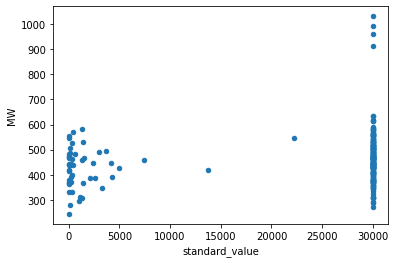

In [ ]:
combined_info.plot.scatter(x='standard_value', y='MW')

Let's try taking the negative log of molar value $(nM \times 10^{-9})$ of $K_d$ in order to obtain a more even distribution and replace the standard_value column with a -logKd column using the below function

In [ ]:
def logKd(input):
    logKd = []

    for i in input['standard_value']:
# Convert nM to M
        molar = i*(10**-9) 
        logKd.append(-np.log10(molar))

    input['-logKd'] = logKd
    x = input.drop('standard_value', 1)
        
    return x

In [ ]:
df_final = logKd(combined_info)
df_final

,molecule_pref_name,molecule_chembl_id,canonical_smiles,bioactivity,MW,LogP,No_H-Donors,No_H-Acceptors,-logKd
0,ABEMACICLIB,CHEMBL3301610,CCN1CCN(Cc2ccc(Nc3ncc(F)c(-c4cc(F)c5nc(C)n(C(C...,active,506.605,4.93692,1,8,6.991400
1,LUCITANIB,CHEMBL2220486,CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...,inactive,443.503,4.41860,2,6,4.522879
2,SUNITINIB,CHEMBL535,CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...,active,398.482,3.33494,3,3,6.440093
3,OSI-632,CHEMBL253969,NC(=O)c1c(OCc2c(F)cc(Br)cc2F)nsc1NC(=O)NCCCCN1...,inactive,532.411,3.85920,3,6,4.522879
4,ICOTINIB,CHEMBL2087361,C#Cc1cccc(Nc2ncnc3cc4c(cc23)OCCOCCOCCO4)c1,inactive,391.427,3.15910,1,7,4.522879
...,...,...,...,...,...,...,...,...,...
237,FASUDIL,CHEMBL38380,O=S(=O)(c1cccc2cnccc12)N1CCCNCC1,inactive,291.376,1.21880,1,4,4.522879
238,FOSTAMATINIB,CHEMBL2103830,COc1cc(Nc2ncc(F)c(Nc3ccc4c(n3)N(COP(=O)(O)O)C(...,inactive,580.466,3.09450,4,12,4.522879
239,TIVANTINIB,CHEMBL2103882,O=C1NC(=O)[C@@H](c2cn3c4c(cccc24)CCC3)[C@@H]1c...,inactive,369.424,3.59260,2,3,4.522879
240,AXITINIB,CHEMBL1289926,CNC(=O)c1ccccc1Sc1ccc2c(/C=C/c3ccccn3)n[nH]c2c1,intermediate activity,386.480,4.63910,2,4,5.665747


## **Top 20 Most Active Compounds**

In [ ]:
top_20 = df_final.sort_values(by=['-logKd'], ascending=False).head(20)
top_20

,molecule_pref_name,molecule_chembl_id,canonical_smiles,bioactivity,MW,LogP,No_H-Donors,No_H-Acceptors,-logKd
91,None,CHEMBL3991929,CCS(=O)(=O)N1CCN(c2ccc(Nc3ncc(C(N)=O)c(NC4CC4)...,highly active,482.010,1.78690,3,8,9.000000
95,PF-00477736,CHEMBL3545137,Cn1cc(-c2nc3cc(NC(=O)C(N)C4CCCCC4)cc4c3-c2c[nH...,highly active,419.489,1.98950,4,7,8.698970
84,MOMELOTINIB,CHEMBL1078178,N#CCNC(=O)c1ccc(-c2ccnc(Nc3ccc(N4CCOCC4)cc3)n2...,highly active,414.469,2.97718,2,7,8.397940
191,K-252A,CHEMBL281948,COC(=O)[C@@]1(O)C[C@H]2O[C@]1(C)n1c3ccccc3c3c4...,highly active,467.481,3.65510,2,7,8.301030
50,CYC-116,CHEMBL482967,Cc1nc(N)sc1-c1ccnc(Nc2ccc(N3CCOCC3)cc2)n1,highly active,368.466,3.07092,2,8,8.221849
185,XL-019,CHEMBL3545328,O=C(Nc1ccc(-c2ccnc(Nc3ccc(N4CCOCC4)cc3)n2)cc1)...,highly active,444.539,3.41430,3,7,8.221849
18,None,CHEMBL1983111,CC(=O)NCC(=O)N1C2CCC1c1cc(Nc3ncc(C(F)(F)F)c(NC...,highly active,474.487,4.05770,3,6,8.045757
223,SAR-407899,CHEMBL1667969,O=c1[nH]ccc2cc(OC3CCNCC3)ccc12,active,244.294,1.65890,2,3,7.920819
105,AT-9283,CHEMBL495727,O=C(Nc1c[nH]nc1-c1nc2ccc(CN3CCOCC3)cc2[nH]1)NC...,active,381.440,2.06910,4,5,7.769551
100,RGB-286638,CHEMBL3545083,COCCN1CCN(Cc2ccc(-c3n[nH]c4c3C(=O)c3c(NC(=O)NN...,active,545.644,2.42080,3,8,7.657577


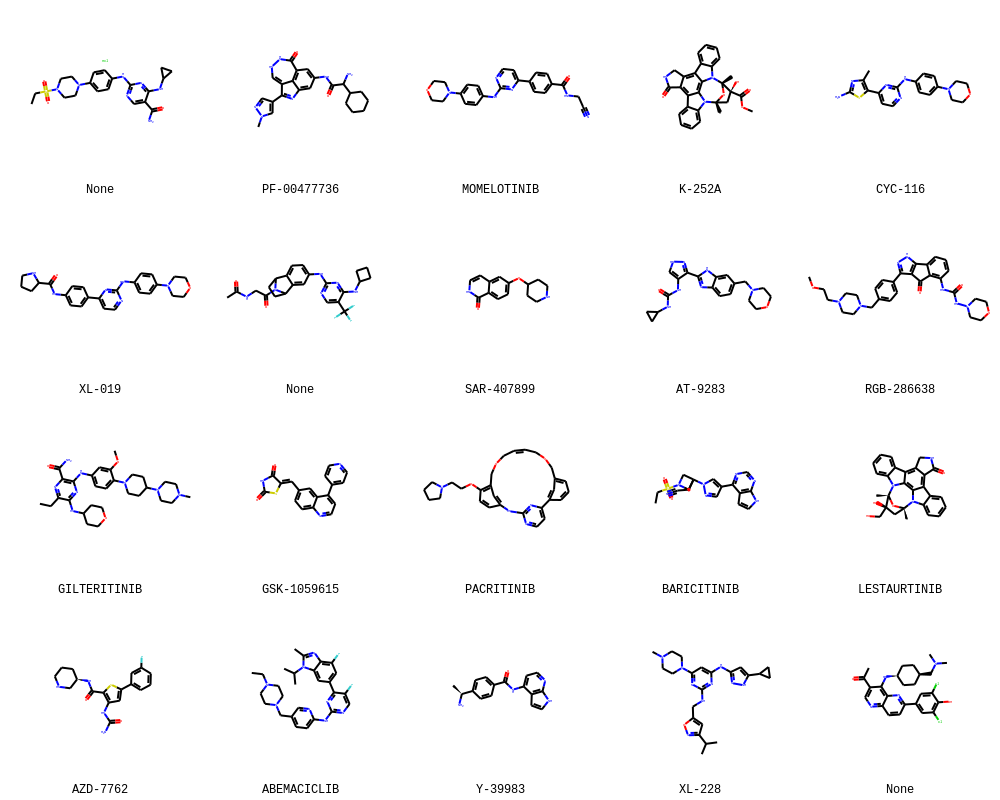

In [ ]:
top_20_list = []
for i in top_20.canonical_smiles:
  mol = Chem.MolFromSmiles(i)
  top_20_list.append(mol)

Draw.MolsToGridImage(top_20_list, molsPerRow=5, legends=[str(x) for x in top_20.molecule_pref_name])

We see that Baricitinib is amongst the top 20 most stable structures amongst other molecules!

## **Chemical Space Analysis**

Let's plot a bioactivity histogram of the AAK1 inhibitors

### **Bioactivity**

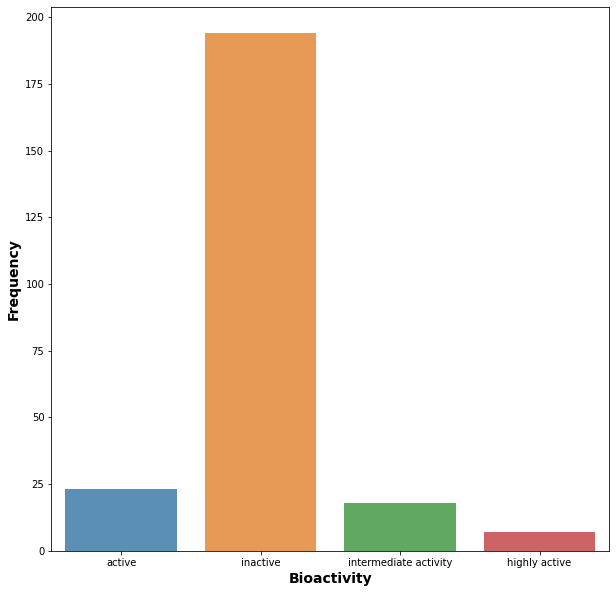

In [ ]:
plt.figure(figsize=(10,10))

sbn.countplot(x='bioactivity', data=df_final, alpha=0.8)

plt.xlabel('Bioactivity', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.show()
# plt.savefig('bioactivity_frequency.pdf')

### **MW vs LogP**

There were a lot of "inactive" compounds found. Do the inactive and active compounds share similar features? Like MW and LogP

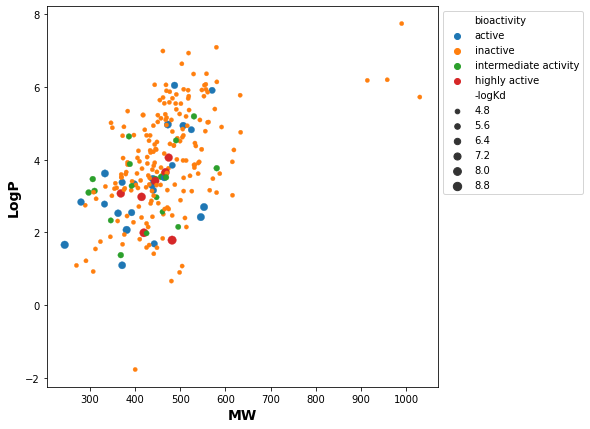

In [ ]:
plt.figure(figsize=(7,7))

sbn.scatterplot(x='MW', y='LogP', data=combined_info, hue='bioactivity', size='-logKd', edgecolor=None)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.show()
# plt.savefig('MW_vs_LogP.png')

## **Investigating the distribution of bioactivity with different properties**

### **$-log(K_d)$**

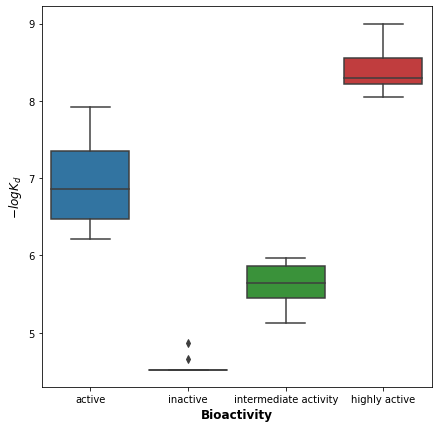

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(7,7))

sbn.boxplot(x='bioactivity', y='-logKd', data=combined_info)

plt.xlabel('Bioactivity', fontsize=12, fontweight='bold')
plt.ylabel(r'$-logK_d$', fontsize=12, fontweight='bold')
plt.show()
#plt.savefig('distr_logkd.png', dpi=300)

### **H-acceptors**

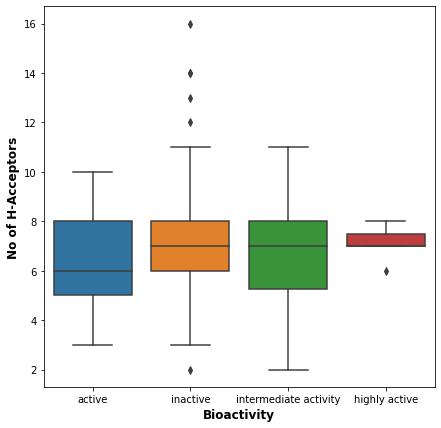

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(7,7))

sbn.boxplot(x='bioactivity', y='No_H-Acceptors', data=combined_info)

plt.xlabel('Bioactivity', fontsize=12, fontweight='bold')
plt.ylabel('No of H-Acceptors', fontsize=12, fontweight='bold')
plt.show()
#plt.savefig('distr_H-acceptors.png')

### **H-donors**

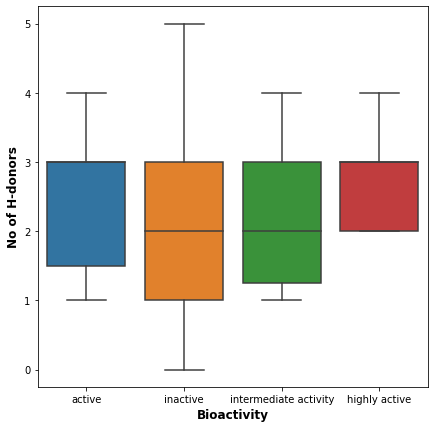

In [ ]:
plt.figure(figsize=(7,7))

sbn.boxplot(x='bioactivity', y='No_H-Donors', data=combined_info)

plt.xlabel('Bioactivity', fontsize=12, fontweight='bold')
plt.ylabel('No of H-donors', fontsize=12, fontweight='bold')
plt.show()
#plt.savefig('distr_H-donors.png')

### **$logP$**

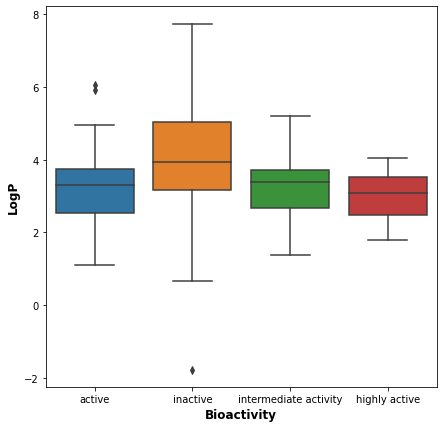

In [ ]:
plt.figure(figsize=(7,7))

sbn.boxplot(x='bioactivity', y='LogP', data=combined_info)

plt.xlabel('Bioactivity', fontsize=12, fontweight='bold')
plt.ylabel('LogP', fontsize=12, fontweight='bold')
plt.show()
#plt.savefig('distr_logp.png')

### **MW**

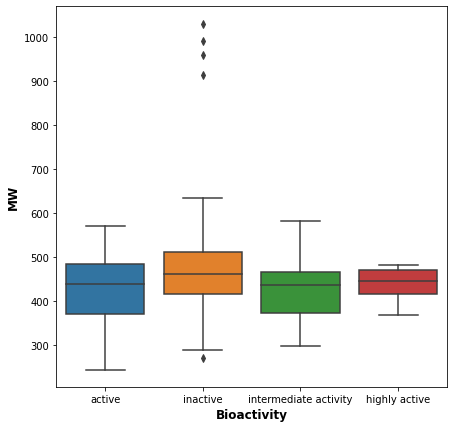

In [ ]:
plt.figure(figsize=(7,7))

sbn.boxplot(x='bioactivity', y='MW', data=combined_info)

plt.xlabel('Bioactivity', fontsize=12, fontweight='bold')
plt.ylabel('MW', fontsize=12, fontweight='bold')
plt.show()
#plt.savefig('distr_MW.png')

## **The Mann-Whitney U Test**

Let's investigate the statistical differences between the inactive and active molecules for each property/descriptor.

A p below our $\alpha$ can be intepretted as the showing statistically significant differences.

https://www.statstutor.ac.uk/resources/uploaded/mannwhitney.pdf

In [ ]:
# the below function has been obtained from the amazing work of https://github.com/dataprofessor
def mannwhitney(descriptor, verbose=False):
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(100)

# actives and inactives
  selection = [descriptor, 'bioactivity']
  df = combined_info[selection]
  active = df[df['bioactivity'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity']
  df = combined_info[selection]
  inactive = df[df['bioactivity'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject null hyp)'
  else:
    interpretation = 'Different distribution (reject null hyp)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])

  return results

**Our pIC50s will definitely have a different distribution as we classed the bioactivities as such.**

In [ ]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1727.0,0.038491,0.05,Different distribution (reject null hyp)


In [ ]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,1537.0,0.007429,0.05,Different distribution (reject null hyp)


In [ ]:
mannwhitney('No_H-Acceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,No_H-Acceptors,1897.0,0.117545,0.05,Same distribution (fail to reject null hyp)


There does not seem to be a significant enough statistical difference between the No of H-acceptors found in inactive and active compounds!

(More data required)

In [ ]:
mannwhitney('No_H-Donors')

,Descriptor,Statistics,p,alpha,Interpretation
0,No_H-Donors,1698.0,0.024725,0.05,Different distribution (reject null hyp)


**Let's attempt to train a model with a bigger dataset. Like AChE inhibitors...**